In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from tree import Tree
import tree_to_prism as tp

In [2]:
file = 'trees/adt_nuovo.xml'
tree = Tree()
tree = tp.parse_file(file)
tree.root.to_string()

'Label: DataExfiltration\nRefinement: disjunctive\nType: Goal\nAction: \nCost: \nRole: Attacker'

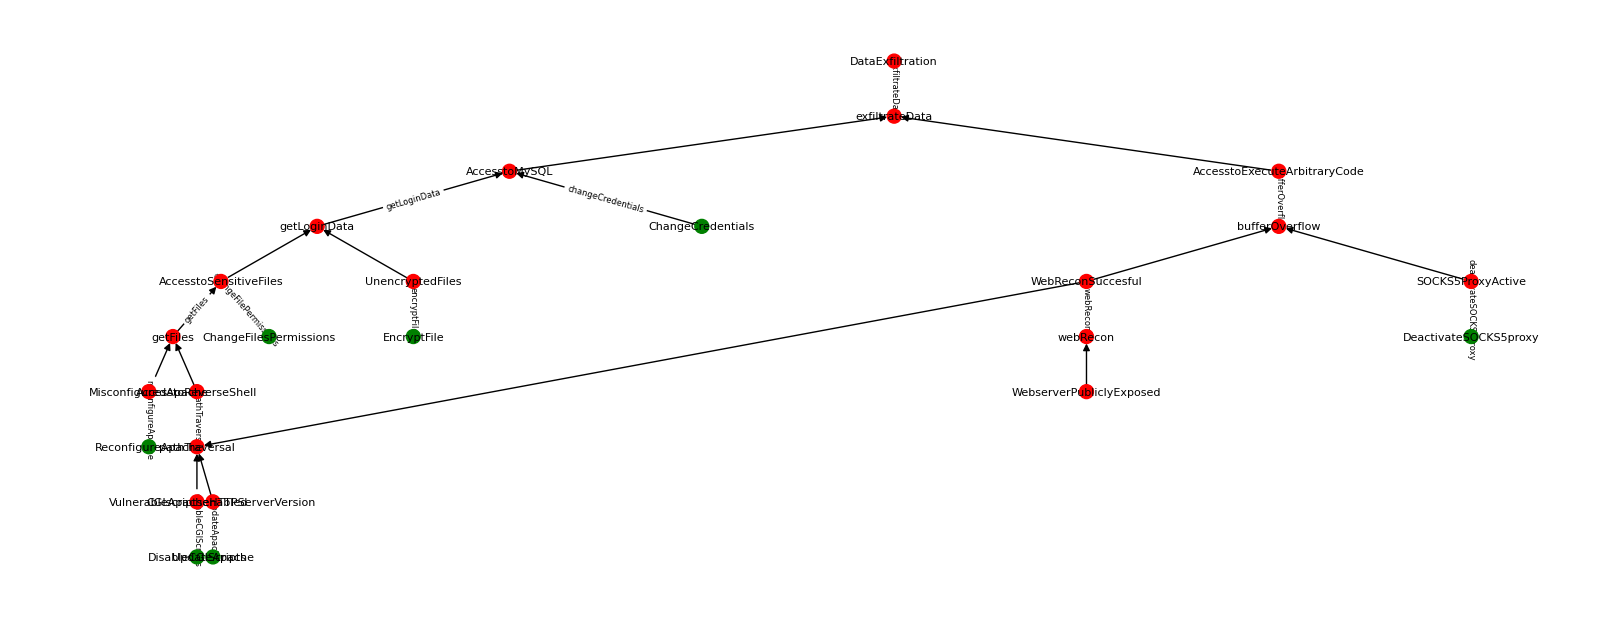

In [3]:
G = tree.to_graph()

fig = plt.figure(figsize=(16, 6))
pos = tree.hierarchy_pos(G, tree.root.label, width=500, xcenter=0.5) # get the position of the nodes

colors = []
for node in G.nodes: 
    colors.append(G.nodes[node]['color']) 
    
nx.draw(nx.reverse(G), pos, node_color=colors, with_labels=True, arrows=True, node_size=100, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'action') # get the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6) 

plt.show()

In [4]:
df = tree.to_dataframe()
df.head()

,Label,Refinement,Type,Action,Cost,Role,Time,Parent,Children
0,DataExfiltration,disjunctive,Goal,,,Attacker,,None,{exfiltrateData}
1,exfiltrateData,disjunctive,Action,exfiltrateData,50,Attacker,2,DataExfiltration,"{AccesstoExecuteArbitraryCode, AccesstoMySQL}"
2,AccesstoMySQL,conjunctive,Attribute,,,Attacker,,exfiltrateData,"{ChangeCredentials, getLoginData}"
3,AccesstoExecuteArbitraryCode,conjunctive,Attribute,,,Attacker,,exfiltrateData,{bufferOverflow}
4,getLoginData,conjunctive,Action,getLoginData,10,Attacker,2,AccesstoMySQL,"{UnencryptedFiles, AccesstoSensitiveFiles}"


In [5]:
model = tp.get_prism_model(tree) # get the prism model as a string
model_time = tp.get_prism_model_time(tree) # get the prism model with time as a string

exfiltrateData ['AccesstoExecuteArbitraryCode', 'AccesstoMySQL']
getLoginData ['UnencryptedFiles', 'AccesstoSensitiveFiles']
changeCredentials []
bufferOverflow ['SOCKS5ProxyActive', 'WebReconSuccesful']
getFiles ['MisconfiguredApache', 'AccesstoReverseShell']
changeFilePermissions []
encryptFile []
webRecon ['WebserverPubliclyExposed']
deactivateSOCKS5Proxy []
reconfigureApache []
pathTraversal ['CGIscriptsenabled', 'VulnerableApacheHTTPServerVersion', 'WebReconSuccesful']
webRecon ['WebserverPubliclyExposed']
disableCGIScripts []
updateApache []
{'exfiltrateData': {'preconditions': ['AccesstoExecuteArbitraryCode', 'AccesstoMySQL'], 'effect': 'DataExfiltration', 'cost': '50', 'time': '2', 'refinement': 'disjunctive'}, 'getLoginData': {'preconditions': ['UnencryptedFiles', 'AccesstoSensitiveFiles'], 'effect': 'AccesstoMySQL', 'cost': '10', 'time': '2', 'refinement': 'conjunctive'}, 'bufferOverflow': {'preconditions': ['SOCKS5ProxyActive', 'WebReconSuccesful'], 'effect': 'AccesstoExecut

In [6]:
tp.save_prism_model(model, 'prism/new_tree.prism')  # save the model to a file
tp.save_prism_model(model_time, 'prism/new_tree_time.prism')  # save the model with time to a file

In [11]:
# get defender actions sorted by cost
defender_actions = df[df['Role'] == 'Defender']
defender_actions = defender_actions[defender_actions['Action'] != '']
defender_actions.loc[:, 'Cost'] = defender_actions.loc[:, 'Cost'].astype(int)
defender_actions = defender_actions.sort_values(by='Cost')
display(defender_actions)

,Label,Refinement,Type,Action,Cost,Role,Time,Parent,Children
26,UpdateApache,conjunctive,Action,updateApache,20,Defender,20,VulnerableApacheHTTPServerVersion,{}
25,DisableCGIScripts,conjunctive,Action,disableCGIScripts,45,Defender,1,CGIscriptsenabled,{}
19,ReconfigureApache,conjunctive,Action,reconfigureApache,50,Defender,2,MisconfiguredApache,{}
12,ChangeFilesPermissions,conjunctive,Action,changeFilePermissions,60,Defender,2,AccesstoSensitiveFiles,{}
15,DeactivateSOCKS5proxy,conjunctive,Action,deactivateSOCKS5Proxy,120,Defender,1,SOCKS5ProxyActive,{}
13,EncryptFile,disjunctive,Action,encryptFile,150,Defender,5,UnencryptedFiles,{}
5,ChangeCredentials,disjunctive,Action,changeCredentials,200,Defender,2,AccesstoMySQL,{}


In [12]:
# get the attacker actions sorted by cost
attacker_actions = df[df['Role'] == 'Attacker']
attacker_actions = attacker_actions[attacker_actions['Action'] != '']
attacker_actions.loc[:, 'Cost'] = attacker_actions.loc[:, 'Cost'].astype(int)
attacker_actions = attacker_actions.sort_values(by='Cost')
display(attacker_actions)

,Label,Refinement,Type,Action,Cost,Role,Time,Parent,Children
14,webRecon,disjunctive,Action,webRecon,5,Attacker,1,WebReconSuccesful,{WebserverPubliclyExposed}
24,webRecon,disjunctive,Action,webRecon,5,Attacker,1,WebReconSuccesful,{WebserverPubliclyExposed}
4,getLoginData,conjunctive,Action,getLoginData,10,Attacker,2,AccesstoMySQL,"{UnencryptedFiles, AccesstoSensitiveFiles}"
20,pathTraversal,conjunctive,Action,pathTraversal,20,Attacker,2,AccesstoReverseShell,"{CGIscriptsenabled, VulnerableApacheHTTPServer..."
11,getFiles,conjunctive,Action,getFiles,30,Attacker,2,AccesstoSensitiveFiles,"{MisconfiguredApache, AccesstoReverseShell}"
6,bufferOverflow,conjunctive,Action,bufferOverflow,40,Attacker,2,AccesstoExecuteArbitraryCode,"{SOCKS5ProxyActive, WebReconSuccesful}"
1,exfiltrateData,disjunctive,Action,exfiltrateData,50,Attacker,2,DataExfiltration,"{AccesstoExecuteArbitraryCode, AccesstoMySQL}"
